# Proyecto final
## Generador de Beats Hip-Hop
Carlos Magaña, Ignacio Méndez y Diego Soto

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
audio_dir = "/content/drive/My Drive/audio"


### Carga de librerias

In [3]:
#!pip install librosa soundfile

import os
import glob
import math
import random
import librosa
import numpy as np
import soundfile as sf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os, pandas as pd
from datasets import Dataset, Audio

from IPython.display import Audio, display
from google.colab import files

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

AUDIO_DIR = "/content/drive/My Drive/audio"
SR = 16000
DURATION = 10.0
N_MELS = 64
HOP_LENGTH = 512
N_FFT = 1024


Device: cuda


### Limpieza de audios

In [5]:
class HiphopBeatsDataset(Dataset):
    '''
    Dataset que carga audios desde un directorio, los ajusta a una duración fija
    y los convierte en espectrogramas Mel normalizados. Devuelve tensores
    (1, n_mels, tiempo) listos para usar en modelos de audio.
    '''

    def __init__(self, audio_dir, sr=16000, duration=10.0,
                 n_mels=64, n_fft=1024, hop_length=512):
        self.paths = []
        for ext in ("*.mp32", "*.wav", "*.flac", "*.ogg"):
            self.paths.extend(glob.glob(os.path.join(audio_dir, ext)))
        self.sr = sr
        self.duration = duration
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        print("Total archivos:", len(self.paths))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y, sr = librosa.load(path, sr=self.sr, mono=True)
        target_len = int(self.duration * self.sr)

        if len(y) < target_len:
            # padding
            pad = target_len - len(y)
            y = np.pad(y, (0, pad))
        else:
            # recorte aleatorio
            start = np.random.randint(0, len(y) - target_len + 1)
            y = y[start:start + target_len]

        mel = librosa.feature.melspectrogram(
            y=y, sr=self.sr, n_fft=self.n_fft,
            hop_length=self.hop_length, n_mels=self.n_mels
        )
        mel = librosa.power_to_db(mel, ref=np.max)  # dB

        # normalizar aprox a [0, 1]
        mel_norm = (mel + 80.0) / 80.0
        mel_norm = np.clip(mel_norm, 0.0, 1.0)

        # shape: (1, n_mels, time)
        mel_tensor = torch.from_numpy(mel_norm).float().unsqueeze(0)
        return mel_tensor


In [6]:
dataset = HiphopBeatsDataset(AUDIO_DIR, sr=SR, duration=DURATION,
                             n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)

batch_size = 8
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)


Total archivos: 497


### Modelo ConvVAE

In [7]:
class ConvVAE(nn.Module):
    '''
    VAE convolucional para espectrogramas: codifica a un espacio latente y
    reconstruye la entrada a partir de ese vector latente.
    '''

    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        dummy = torch.zeros(1, 1, N_MELS,  int(DURATION * SR / HOP_LENGTH) + 1)
        with torch.no_grad():
            h = self.enc(dummy)
        self.enc_out_shape = h.shape[1:]  # (C,H',W')
        enc_flat_dim = h.numel()

        self.fc_mu = nn.Linear(enc_flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_flat_dim, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)
        C, H, W = self.enc_out_shape
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),  # salidas en [0,1]
        )
    # Pasa el espectrograma por el encoder y obtiene media y log-varianza del latente.
    def encode(self, x):
        h = self.enc(x)
        h_flat = h.view(h.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar

    # Reparametrización: mu + std * eps para hacer muestreable el latente.
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # Decodifica un vector latente para reconstruir el espectrograma.
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), *self.enc_out_shape)
        x_rec = self.dec(h)
        return x_rec

    # Flujo completo del VAE: encode → reparam → decode, devuelve reconstrucción y parámetros latentes.
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        x_rec = self.decode(z)
        return x_rec, mu, logvar


In [8]:
def vae_loss(recon_x, x, mu, logvar, beta=0.001):

    '''
    Función de pérdida del VAE: combina MSE de reconstrucción y término KL,
    ajustando ambos espectrogramas al mismo tamaño antes de calcular la pérdida.
    '''
    # Igualar tamaños
    _, _, H_r, W_r = recon_x.shape
    _, _, H_x, W_x = x.shape

    H_min = min(H_r, H_x)
    W_min = min(W_r, W_x)

    recon_x_c = recon_x[:, :, :H_min, :W_min]
    x_c       = x[:, :, :H_min, :W_min]

    # MSE de reconstrucción
    recon = nn.functional.mse_loss(recon_x_c, x_c, reduction="sum")

    # KL con peso beta
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (recon + beta * kl) / x.size(0)


In [9]:
CHECKPOINT_DIR = "/content/drive/MyDrive/vae_checkpoints1"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print("Guardaré los modelos en:", CHECKPOINT_DIR)


Guardaré los modelos en: /content/drive/MyDrive/vae_checkpoints1


### Hiperparametros

In [11]:
# Lista de hiperparametros usados en el modelo

latent_dim = 256

model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

epochs = 50


### Entrenamiento

In [ ]:
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(batch)

        # Valores para función de perdida
        loss = vae_loss(recon, batch, mu, logvar, beta=0.001)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

    # Guarda checkpoint cada 10 epochs
    if epoch % 10 == 0:
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"vae_hiphop_epoch_{epoch}.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Checkpoint guardado en: {ckpt_path}")


Epoch 1/50 - Loss: 571.6737
Epoch 2/50 - Loss: 367.3573
Epoch 3/50 - Loss: 328.6654
Epoch 4/50 - Loss: 308.8223
Epoch 5/50 - Loss: 292.2743
Epoch 6/50 - Loss: 293.0274
Epoch 7/50 - Loss: 277.7920
Epoch 8/50 - Loss: 275.5140
Epoch 9/50 - Loss: 265.2966
Epoch 10/50 - Loss: 255.5874
✅ Checkpoint guardado en: /content/drive/MyDrive/vae_checkpoints1/vae_hiphop_epoch_10.pt
Epoch 11/50 - Loss: 252.4814
Epoch 12/50 - Loss: 244.7812
Epoch 13/50 - Loss: 245.8853
Epoch 14/50 - Loss: 243.2315
Epoch 15/50 - Loss: 240.1008
Epoch 16/50 - Loss: 240.8061
Epoch 17/50 - Loss: 238.2906
Epoch 18/50 - Loss: 231.7736
Epoch 19/50 - Loss: 228.9028
Epoch 20/50 - Loss: 230.5701
✅ Checkpoint guardado en: /content/drive/MyDrive/vae_checkpoints1/vae_hiphop_epoch_20.pt
Epoch 21/50 - Loss: 224.3634
Epoch 22/50 - Loss: 222.9819
Epoch 23/50 - Loss: 221.8021
Epoch 24/50 - Loss: 214.4732
Epoch 25/50 - Loss: 210.5339
Epoch 26/50 - Loss: 208.8754
Epoch 27/50 - Loss: 212.4131
Epoch 28/50 - Loss: 206.4302
Epoch 29/50 - Loss:

In [12]:
def load_conv_vae(checkpoint_path, latent_dim=256, device=device):
    '''
    Carga un modelo ConvVAE desde un checkpoint.
    '''
    model = ConvVAE(latent_dim=latent_dim).to(device)
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model


### Carga de modelo

In [13]:
model = load_conv_vae("/content/drive/MyDrive/vae_checkpoints1/vae_hiphop_epoch_50.pt")


### Generación de audios con modelo

In [ ]:
model.eval()

def generate_audio(num_samples=3):
    '''
    Genera nuevos audios sampleando vectores latentes aleatorios
    y decodificándolos con el VAE; invierte el melspectrograma a audio.
    '''
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        mel_hat = model.decode(z)
        mel_hat = mel_hat.squeeze(1).cpu().numpy()

    audios = []
    for i in range(num_samples):
        mel = mel_hat[i]
        # des-normalizar
        mel_db = mel * 80.0 - 80.0  # inverso de (mel+80)/80
        mel_power = librosa.db_to_power(mel_db)

        # invertir melspec -> waveform con Griffin-Lim
        y = librosa.feature.inverse.mel_to_audio(
            mel_power,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_iter=64
        )
        audios.append(y)
    return audios

gen_audios = generate_audio(num_samples=3)

for i, y in enumerate(gen_audios):
    fname = f"vae_hiphop_gen_{i}.wav"
    sf.write(fname, y, SR)
    print("Guardado:", fname)


Guardado: vae_hiphop_gen_0.wav
Guardado: vae_hiphop_gen_1.wav
Guardado: vae_hiphop_gen_2.wav


In [ ]:

display(Audio("vae_hiphop_gen_0.wav", rate=SR))


In [ ]:
# Descarga de audios generados

files.download("vae_hiphop_gen_0.wav")
files.download("vae_hiphop_gen_1.wav")
files.download("vae_hiphop_gen_2.wav")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Explainable AI (XAI)

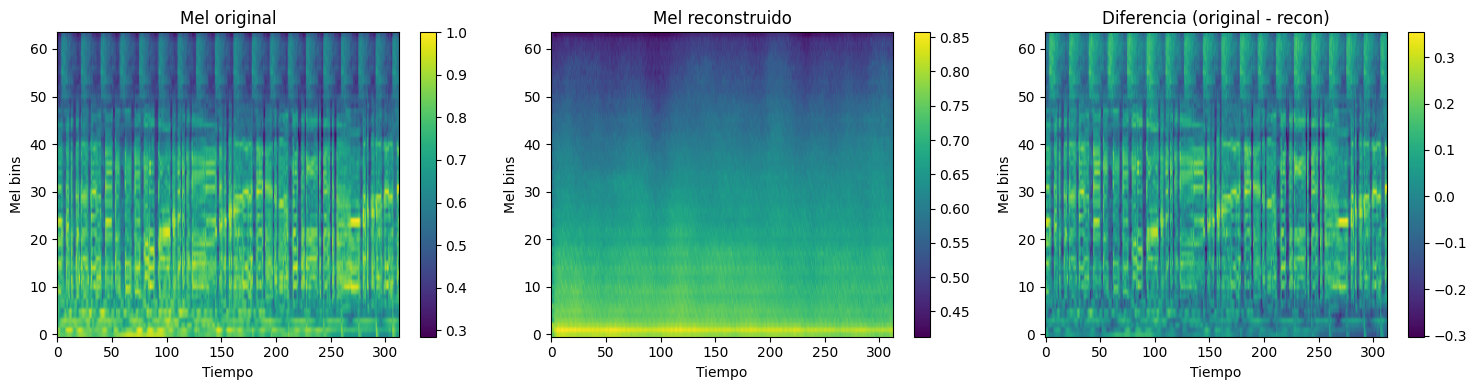

In [ ]:


def plot_mel_reconstruction(model, dataset, idx=0, device=device):
    '''
    Grafica un mel-spectrograma original, su reconstrucción del VAE
    y la diferencia entre ambos para visualizar la calidad del modelo.
    '''

    model.eval()

    x = dataset[idx]
    with torch.no_grad():
        inp = x.unsqueeze(0).to(device)
        recon, mu, logvar = model(inp)

    orig = x.squeeze(0).cpu().numpy()
    rec  = recon.squeeze(0).squeeze(0).cpu().numpy()

    # Ajustar a tamaños mínimos
    H_min = min(orig.shape[0], rec.shape[0])
    W_min = min(orig.shape[1], rec.shape[1])

    orig_c = orig[:H_min, :W_min]
    rec_c  = rec[:H_min, :W_min]
    diff   = orig_c - rec_c   # diferencia punto a punto

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axs[0].imshow(orig_c, origin="lower", aspect="auto")
    axs[0].set_title("Mel original")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(rec_c, origin="lower", aspect="auto")
    axs[1].set_title("Mel reconstruido")
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(diff, origin="lower", aspect="auto")
    axs[2].set_title("Diferencia (original - recon)")
    plt.colorbar(im2, ax=axs[2])

    for ax in axs:
        ax.set_xlabel("Tiempo")
        ax.set_ylabel("Mel bins")

    plt.tight_layout()
    plt.show()

# Muestra original, reconstrucción y diferencia lado a lado.
plot_mel_reconstruction(model, dataset, idx=0, device=device)


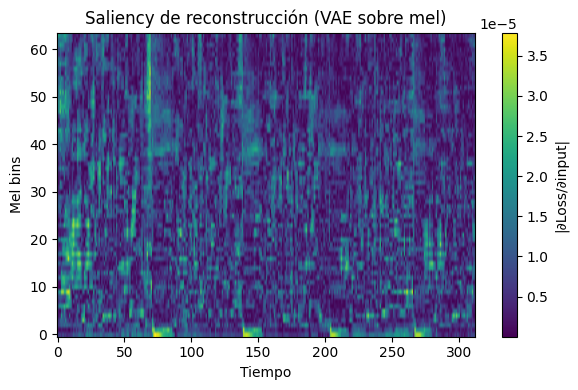

In [ ]:

def mel_reconstruction_saliency(model, x, device=device):

    '''
    Calcula un mapa de saliencia indicando qué partes del mel afectan más
    a la reconstrucción del VAE (derivada de la pérdida respecto al input).
    '''
    model.eval()

    if x.dim() == 3:
        x = x.unsqueeze(0)

    x = x.to(device)
    x = x.clone().detach().requires_grad_(True)

    recon, mu, logvar = model(x)

    # Ajuste de tamaños con vae_loss
    _, _, H_r, W_r = recon.shape
    _, _, H_x, W_x = x.shape
    H_min = min(H_r, H_x)
    W_min = min(W_r, W_x)

    recon_c = recon[:, :, :H_min, :W_min]
    x_c     = x[:, :, :H_min, :W_min]

    loss = F.mse_loss(recon_c, x_c, reduction="mean")

    model.zero_grad()
    loss.backward()

    saliency = x.grad.detach().abs().squeeze(0).squeeze(0).cpu().numpy()
    return saliency

sample = dataset[0]
sal = mel_reconstruction_saliency(model, sample, device=device)

plt.figure(figsize=(6,4))
plt.imshow(sal, origin="lower", aspect="auto")
plt.title("Saliency de reconstrucción (VAE sobre mel)")
plt.xlabel("Tiempo")
plt.ylabel("Mel bins")
plt.colorbar(label="|∂Loss/∂input|")
plt.tight_layout()
plt.show()


In [ ]:
def latent_statistics(model, loader, device=device):
    '''
    Calcula estadísticas del espacio latente (media y desviación estándar)
    usando todos los mu generados por el encoder del VAE.
    '''
    model.eval()
    mus = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch)
            mus.append(mu.cpu())

    mus = torch.cat(mus, dim=0)
    mean = mus.mean(dim=0)
    std  = mus.std(dim=0)
    return mean, std


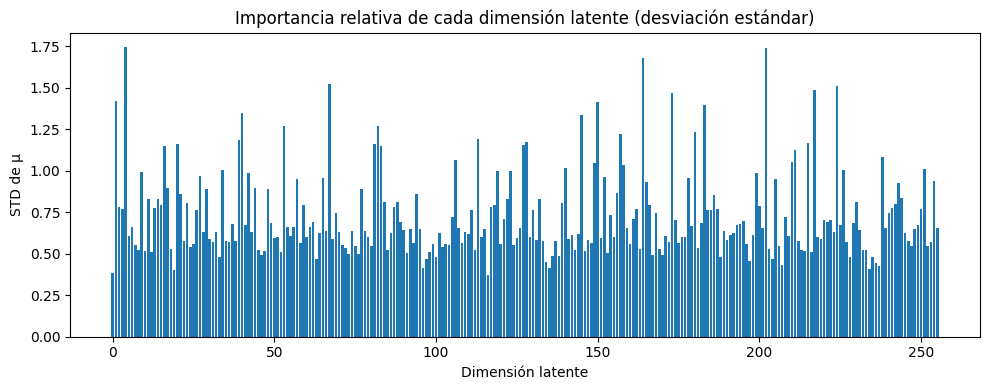

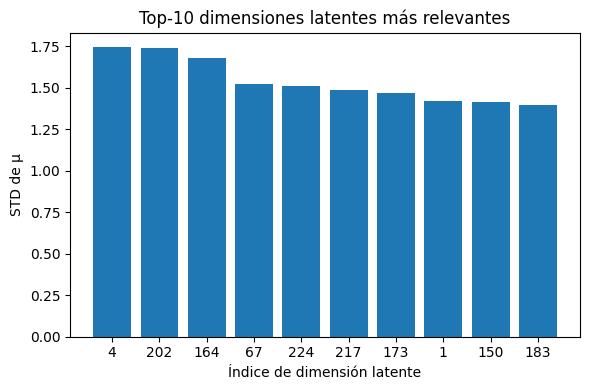

Dimensiones más importantes: [  4 202 164  67 224 217 173   1 150 183]
STD correspondientes: [1.7442967 1.7387441 1.6799686 1.521656  1.5092068 1.4879072 1.4691039
 1.4233148 1.4142503 1.3960631]


In [ ]:
mean_z, std_z = latent_statistics(model, loader, device=device)

std_np = std_z.cpu().numpy()
dims = np.arange(len(std_np))

# Gráfica de cada dimensión latente
plt.figure(figsize=(10,4))
plt.bar(dims, std_np)
plt.title("Importancia relativa de cada dimensión latente (desviación estándar)")
plt.xlabel("Dimensión latente")
plt.ylabel("STD de μ")
plt.tight_layout()
plt.show()

top_k = 10
top_idx = np.argsort(std_np)[::-1][:top_k]

# Gráfica con el top 10 dimensiones latentes más influyentes
plt.figure(figsize=(6,4))
plt.bar(np.arange(top_k), std_np[top_idx])
plt.xticks(np.arange(top_k), top_idx)
plt.title(f"Top-{top_k} dimensiones latentes más relevantes")
plt.xlabel("Índice de dimensión latente")
plt.ylabel("STD de μ")
plt.tight_layout()
plt.show()

print("Dimensiones más importantes:", top_idx)
print("STD correspondientes:", std_np[top_idx])


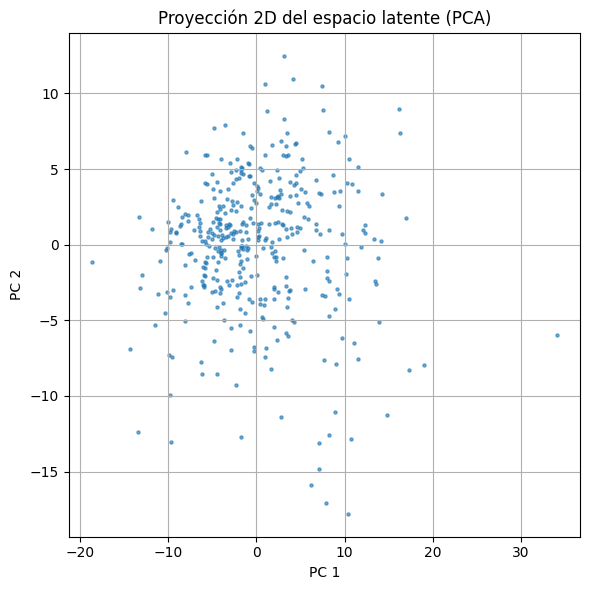

In [ ]:


def get_all_latent_mu(model, loader, device=device, max_batches=None):
    '''
    Extrae todos los vectores mu del encoder del VAE para varias muestras,
    útil para analizar o visualizar la distribución del espacio latente.
    '''

    model.eval()
    mus = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = batch.to(device)
            mu, logvar = model.encode(batch)
            mus.append(mu.cpu())
            if max_batches is not None and i >= max_batches - 1:
                break

    mus = torch.cat(mus, dim=0).numpy()  # (N, latent_dim)
    return mus

# Sacar μ para todas las muestras
all_mu = get_all_latent_mu(model, loader, device=device, max_batches=50)

# Proyectar a 2D con PCA
pca = PCA(n_components=2)
mu_2d = pca.fit_transform(all_mu)

plt.figure(figsize=(6,6))
plt.scatter(mu_2d[:,0], mu_2d[:,1], s=5, alpha=0.6)
plt.title("Proyección 2D del espacio latente (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def reconstruction_mse(model, loader, device=device):
    '''
    Calcula el MSE promedio de reconstrucción del VAE sobre todo el dataset.
    '''

    model.eval()
    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)

            # Igualar tamaños
            _, _, H_r, W_r = recon.shape
            _, _, H_x, W_x = batch.shape
            H_min = min(H_r, H_x)
            W_min = min(W_r, W_x)

            recon_c = recon[:, :, :H_min, :W_min]
            batch_c = batch[:, :, :H_min, :W_min]

            mse = torch.mean((recon_c - batch_c) ** 2).item()

            total_mse += mse * batch.size(0)
            total_samples += batch.size(0)

    return total_mse / total_samples

mse_value = reconstruction_mse(model, loader)
print("📉 Reconstruction MSE:", mse_value)


📉 Reconstruction MSE: 0.012378127329171665


In [ ]:
def reconstruction_mae(model, loader, device=device):
    '''
    Calcula el MAE promedio de reconstrucción del VAE sobre todo el dataset.
    '''
    model.eval()
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)

            _, _, H_r, W_r = recon.shape
            _, _, H_x, W_x = batch.shape
            H_min = min(H_r, H_x)
            W_min = min(W_r, W_x)

            recon_c = recon[:, :, :H_min, :W_min]
            batch_c = batch[:, :, :H_min, :W_min]

            mae = torch.mean(torch.abs(recon_c - batch_c)).item()

            total_mae += mae * batch.size(0)
            total_samples += batch.size(0)

    return total_mae / total_samples

mae_value = reconstruction_mae(model, loader)
print("📉 Reconstruction MAE:", mae_value)


📉 Reconstruction MAE: 0.08745057364144633


In [ ]:
def average_kl(model, loader, device=device):
    '''
    Calcula la divergencia KL promedio del VAE sobre todo el dataset.
    '''
    model.eval()
    total_kl = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            _, mu, logvar = model(batch)

            kl = -0.5 * torch.mean(
                1 + logvar - mu.pow(2) - logvar.exp()
            ).item()

            total_kl += kl * batch.size(0)
            total_samples += batch.size(0)

    return total_kl / total_samples

kl_value = average_kl(model, loader)
print("📉 Average KL divergence:", kl_value)


📉 Average KL divergence: 3.633222614565203


In [ ]:
def latent_utilization_score(model, loader, threshold=0.05, device=device):
    '''
    Estima cuántas dimensiones del espacio latente están siendo usadas (std > threshold).
    '''
    _, std_z = latent_statistics(model, loader, device)
    std_np = std_z.cpu().numpy()

    # Dimensiones activas
    active_dims = np.sum(std_np > threshold)

    return active_dims, std_np

active_dims, std_np = latent_utilization_score(model, loader)
print(f"📊 Latent Utilization Score: {active_dims} dimensiones activas de {latent_dim}")


📊 Latent Utilization Score: 256 dimensiones activas de 256


In [ ]:
def reconstruction_snr(model, loader, device=device):
    '''
    Calcula el SNR promedio entre el mel original y el reconstruido por el VAE.
    '''
    model.eval()
    total_snr = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon,_,_ = model(batch)

            _,_,H_r,W_r = recon.shape
            _,_,H_x,W_x = batch.shape
            H_min = min(H_r, H_x)
            W_min = min(W_r, W_x)

            recon_c = recon[:, :, :H_min, :W_min]
            batch_c = batch[:, :, :H_min, :W_min]

            signal = (batch_c ** 2).mean().item()
            noise  = ((batch_c - recon_c) ** 2).mean().item()

            snr = 10 * np.log10(signal / noise)
            total_snr += snr * batch.size(0)
            total_samples += batch.size(0)

    return total_snr / total_samples

snr_value = reconstruction_snr(model, loader)
print("🔊 Reconstruction SNR:", snr_value, "dB")


🔊 Reconstruction SNR: 15.046249754001474 dB


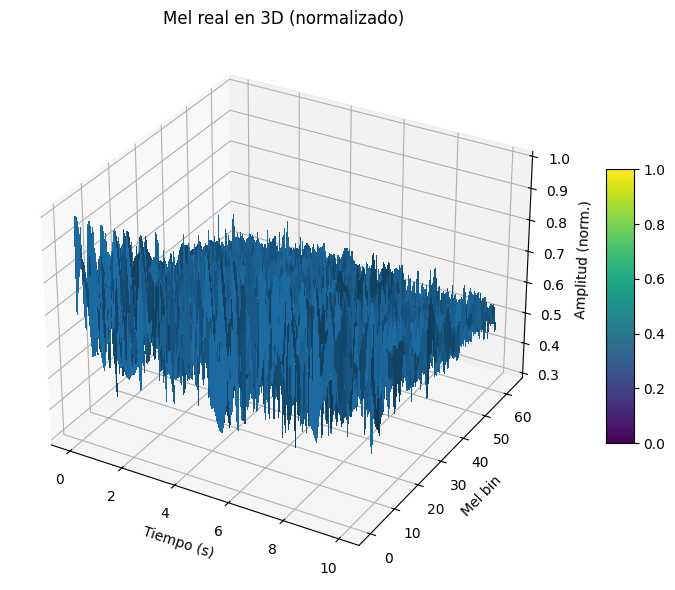

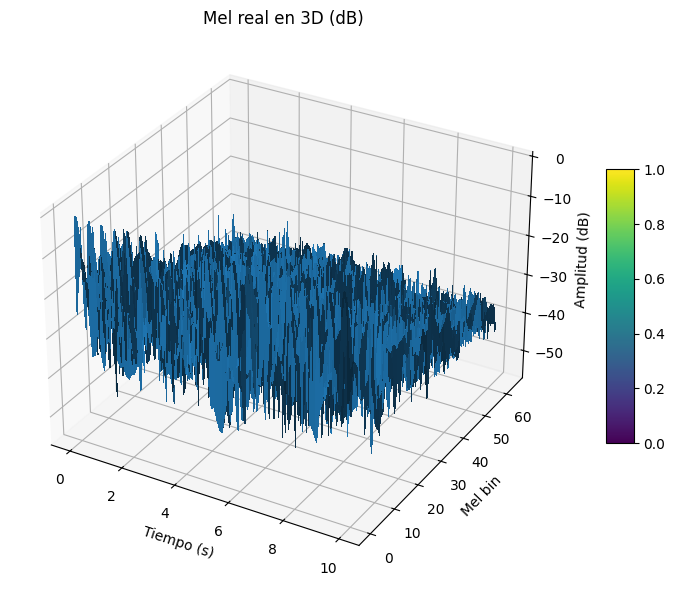

In [14]:


def plot_mel_3d(mel_2d, sr=SR, hop_length=HOP_LENGTH, title="Espectrograma Mel 3D", use_db=False):
    '''
    Grafica un mel-spectrograma en 3D (tiempo, frecuencia Mel y amplitud),
    ya sea normalizado o convertido a dB.
    '''

    if isinstance(mel_2d, torch.Tensor):
        mel_2d = mel_2d.detach().cpu().numpy()

    if mel_2d.ndim == 3:
        mel_2d = mel_2d.squeeze(0)

    n_mels, n_frames = mel_2d.shape

    if use_db:
        mel_db = mel_2d * 80.0 - 80.0
        Z = mel_db
        z_label = "Amplitud (dB)"
    else:
        Z = mel_2d
        z_label = "Amplitud (norm.)"

    times = np.arange(n_frames) * hop_length / sr
    mel_bins = np.arange(n_mels)

    T, F = np.meshgrid(times, mel_bins)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(T, F, Z, linewidth=0, antialiased=False)
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Mel bin")
    ax.set_zlabel(z_label)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

model.eval()
sample_mel = dataset[0]
plot_mel_3d(sample_mel, title="Mel real en 3D (normalizado)", use_db=False)
plot_mel_3d(sample_mel, title="Mel real en 3D (dB)", use_db=True)


In [15]:
def get_latent_mu_and_data(model, loader, device=device, max_batches=None):
    '''
    Extrae los vectores mu del encoder y sus datos originales correspondientes,
    para análisis del espacio latente junto con las muestras reales.
    '''

    model.eval()
    mus = []
    xs  = []
    count = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch)
            mus.append(mu.cpu())
            xs.append(batch.cpu())

            count += 1
            if max_batches is not None and count >= max_batches:
                break

    mus = torch.cat(mus, dim=0)
    xs  = torch.cat(xs,  dim=0)
    return mus, xs


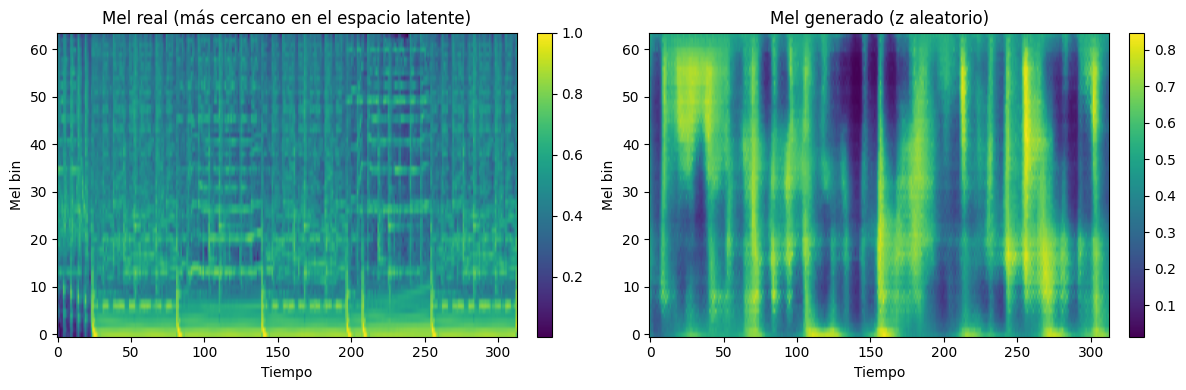

Índice de la muestra real más cercana: 92
Distancia en el espacio latente: 18.4754
Mostrando espectrogramas en 3D...


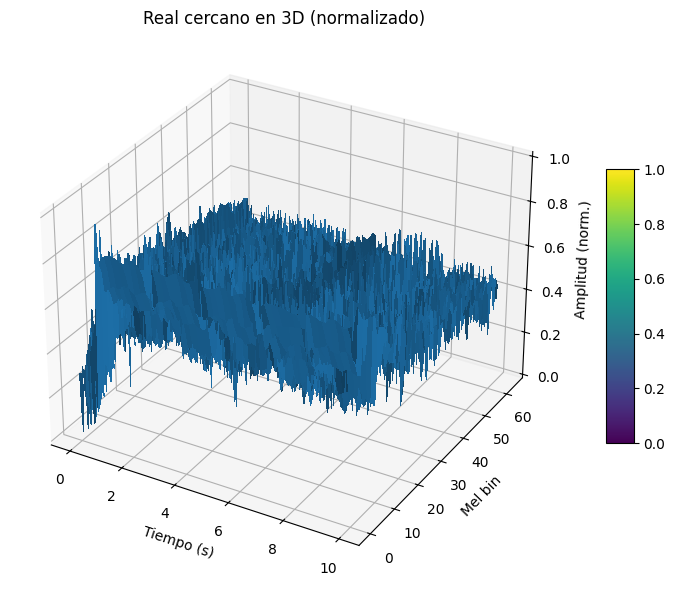

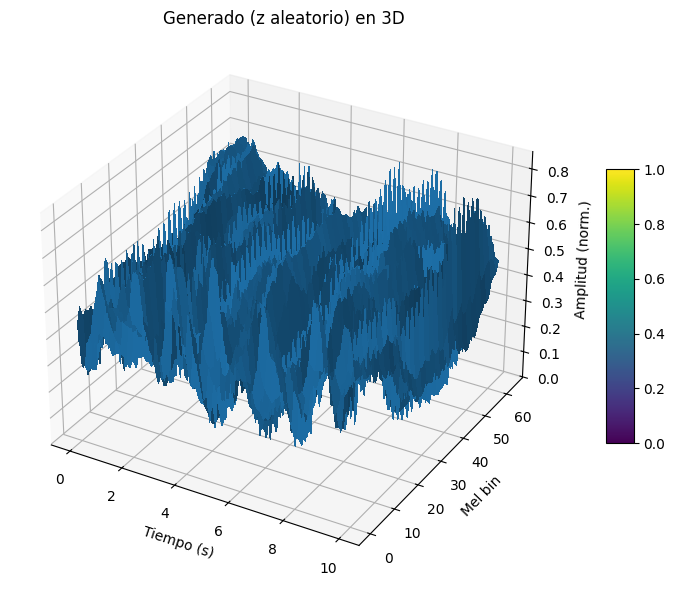

In [16]:
def compare_random_generated_with_closest_real(model, loader, device=device,
                                               max_batches=50, use_3d=False):

    '''
    Compara un mel generado desde un vector latente aleatorio con el mel real
    cuya representación latente (mu) está más cerca; opcionalmente los muestra también en 3D.
    '''
    model.eval()


    mus, xs = get_latent_mu_and_data(model, loader, device=device, max_batches=max_batches)

    latent_dim = mus.shape[1]
    z_random = torch.randn(1, latent_dim)
    z_random_device = z_random.to(device)

    with torch.no_grad():
        mel_gen = model.decode(z_random_device)
    mel_gen = mel_gen.cpu().squeeze(0).squeeze(0).numpy()

    z_random_cpu = z_random.squeeze(0)
    dists = torch.norm(mus - z_random_cpu, dim=1)
    idx_closest = torch.argmin(dists).item()

    mel_real = xs[idx_closest].squeeze(0).numpy()

    H_min = min(mel_real.shape[0], mel_gen.shape[0])
    W_min = min(mel_real.shape[1], mel_gen.shape[1])

    mel_real_c = mel_real[:H_min, :W_min]
    mel_gen_c  = mel_gen[:H_min, :W_min]


    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    im0 = axs[0].imshow(mel_real_c, origin="lower", aspect="auto")
    axs[0].set_title("Mel real (más cercano en el espacio latente)")
    axs[0].set_xlabel("Tiempo")
    axs[0].set_ylabel("Mel bin")
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(mel_gen_c, origin="lower", aspect="auto")
    axs[1].set_title("Mel generado (z aleatorio)")
    axs[1].set_xlabel("Tiempo")
    axs[1].set_ylabel("Mel bin")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print(f"Índice de la muestra real más cercana: {idx_closest}")
    print(f"Distancia en el espacio latente: {dists[idx_closest].item():.4f}")

    if use_3d:
        print("Mostrando espectrogramas en 3D...")
        plot_mel_3d(mel_real_c, title="Real cercano en 3D (normalizado)", use_db=False)
        plot_mel_3d(mel_gen_c,  title="Generado (z aleatorio) en 3D", use_db=False)

compare_random_generated_with_closest_real(model, loader, device=device,
                                           max_batches=50, use_3d=True)
